In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import path
%matplotlib inline

In [2]:
path.insert(0, '../src')
from data_generator import DataGenerator
from model_trainer import ModelTrainer

In [3]:
from data_transformation import get_better_spectra, get_precise_peaks
dg = DataGenerator('../data/classification_cas_data.csv')
norm_data = dg.df()

In [4]:
data = get_better_spectra(dir='../data/SpectraCsvFiles_WatsonPeakFinder/')
norm_data.sort_values('file_name', inplace=True)
data.sort_values('file_name', inplace=True)
norm_data = pd.merge(data, norm_data, on='file_name')

In [5]:
peaks = get_precise_peaks(norm_data, ['precise_channels', 'precise_intensities'])
norm_data['peaks'] = peaks
dg.set_df(norm_data)

In [12]:
from data_transformation import get_isotope_data, get_isotope_mass_list
isotope_data = get_isotope_data()
nom_masses_low = get_isotope_mass_list(isotope_data, False, 2000)
nom_masses_high = get_isotope_mass_list(isotope_data, True, 2000)

In [26]:
original_data = dg.calibrated_df(False)

In [32]:
from data_transformation import get_peaks_near_nom_masses
num_below = []
peaks_below = []
for row in original_data.itertuples():
    peaks, dists = get_peaks_near_nom_masses(row.masses, nom_masses_low, 2000)
    dists = np.array(dists)
    peaks = np.array(peaks)
    num_below.append(len(dists[dists < -0.1]))
    peaks_below.append(peaks[dists < -0.1])

In [33]:
original_data['num_below'] = num_below
original_data['peaks_below'] = peaks_below

In [38]:
weird = original_data[['num_below', 'peaks_below', 'file_name']].copy()
weird.sort_values('num_below', ascending=False)
weird.to_csv('extreme_spectra.csv')

In [10]:
from data_transformation import get_error_masses, get_dist_nom_mass, augment_value
def augment_values(values, amount, sign):
    vals = []
    for val in values:
        vals.append(augment_value(val, amount, sign))
    return vals

def get_avg(masses, nom_mass):
    avgs = 0
    for mass in masses:
        avgs += get_dist_nom_mass(mass, nom_mass)
    return avgs / len(masses)

avgs_slope = []
add_avgs_slope = []
sub_avgs_slope = []
avgs_offset = []
add_avgs_offset = []
sub_avgs_offset = []
avgs_both = []
add_avgs_both = []
sub_avgs_both = []
for num in range(50):
    masses, avgs, sl_err, off_err = get_error_masses(norm_data, False, get_dist_nom_mass, args=(nom_masses_low,), add_to='slope')
    avgs_slope.append(avgs)
    p = pd.Series(np.array(masses, dtype=object)[np.array(sl_err) < 0]).apply(augment_values, args=(0.1, 1,))
    add_avgs_slope.append(p.apply(get_avg, args=(nom_masses_low,)))
    masses, avgs, sl_err, off_err = get_error_masses(norm_data, False, get_dist_nom_mass, args=(nom_masses_low,), add_to='offset')
    avgs_offset.append(avgs)
    p = pd.Series(np.array(masses, dtype=object)[np.array(off_err) < 0]).apply(augment_values, args=(0.1, 1,))
    add_avgs_offset.append(p.apply(get_avg, args=(nom_masses_low,)))
    masses, avgs, sl_err, off_err = get_error_masses(norm_data, False, get_dist_nom_mass, args=(nom_masses_low,), add_to='both')
    avgs_both.append(avgs)
    p = pd.Series(np.array(masses, dtype=object)[np.array(off_err) < 0]).apply(augment_values, args=(0.1, 1,))
    add_avgs_both.append(p.apply(get_avg, args=(nom_masses_low,)))

In [10]:
default = original_data['masses'].apply(get_avg, args=(nom_masses_low,))

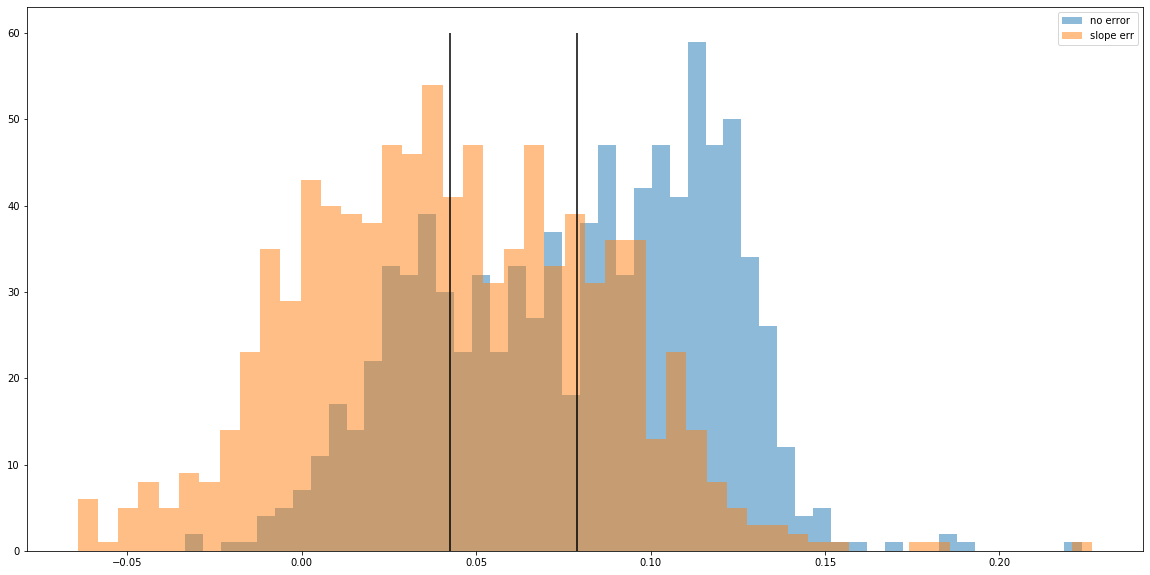

In [11]:
plt.figure(figsize=(20, 10))
plt.hist(default, bins=50, alpha=0.5, label='no error')
plt.vlines(np.mean(default), 0, 60)
plt.hist(avgs_slope[0], bins=50, alpha=0.5, label='slope err')
plt.vlines(np.mean(avgs_slope[0]), 0, 60)
plt.legend()
plt.show()

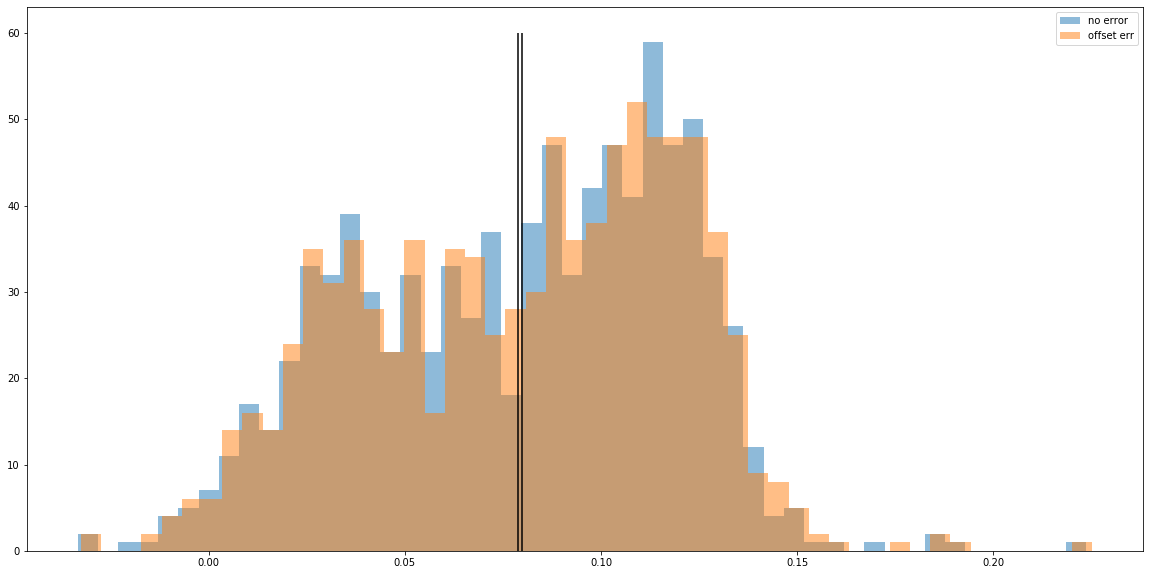

In [12]:
plt.figure(figsize=(20, 10))
plt.hist(default, bins=50, alpha=0.5, label='no error')
plt.vlines(np.mean(default), 0, 60)
plt.hist(avgs_offset[0], bins=50, alpha=0.5, label='offset err')
plt.vlines(np.mean(avgs_offset[0]), 0, 60)
plt.legend()
plt.show()

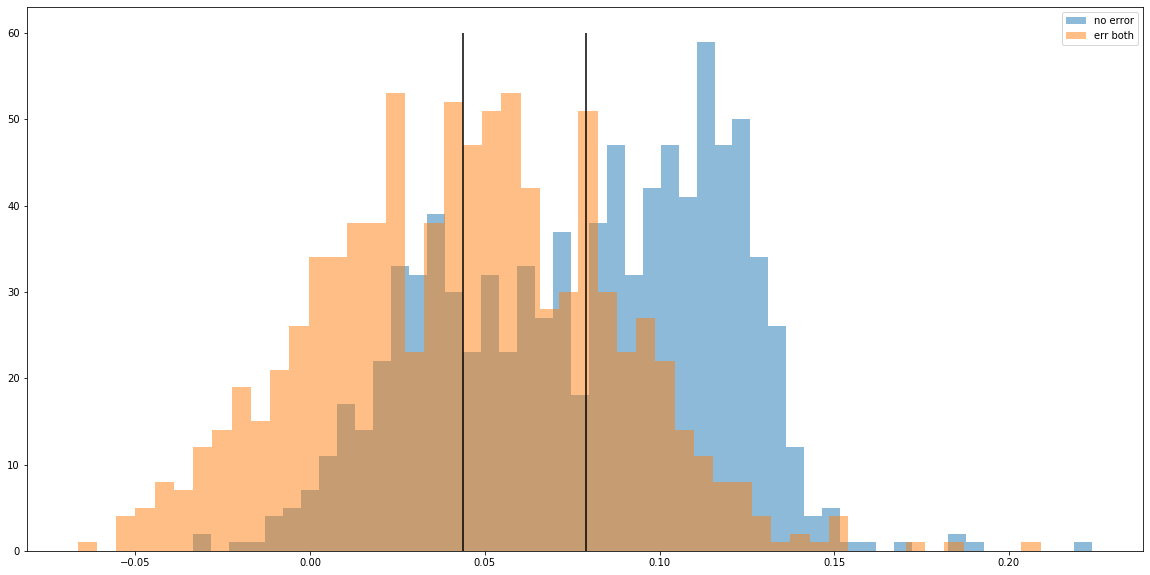

In [13]:
plt.figure(figsize=(20, 10))
plt.hist(default, bins=50, alpha=0.5, label='no error')
plt.vlines(np.mean(default), 0, 60)
plt.hist(avgs_both[0], bins=50, alpha=0.5, label='err both')
plt.vlines(np.mean(avgs_both[0]), 0, 60)
plt.legend()
plt.show()